# Wave speed reconstruction notebook
In this notebook, we reconstruct three different wave speed functions $c$ using our implementation of the ITRC method.

In [1]:
import sys

sys.path.append("../")
import numpy as np
from src.ITRC import ITRC
import src.simulation as simulation
import matplotlib.pyplot as plt

In [2]:
# Parameters of the forward problem
L = 2.5
n_x = 200
dt = 0.01
solver_scale = 5  # The denser forward problem mesh size is scaled using this
T = 2.5

# Parameters of the inverse problem
alpha_vol = 1e-6
alpha_TV = 1e-4
noise_level = 0
CG_maxiter = 20

We generate the three choices of $c$:

In [3]:
# From the oprecnn simulation
c1 = np.vectorize(lambda x: 1)

# Wave speed with bump
c2 = np.vectorize(lambda x: 1 + simulation.bump(x, a=0, b=L, radius=L / 4, deg=3))


# Piecewise constant wave speed (not smooth!)
node_vals = [0, L / 5, 2 * L / 5, 3 * L / 5, 4 * L / 5, L]
pieces = [1.5, 3, 0.75, 1, 0.5, 1]
def c3(x):
    ret = np.piecewise(x, simulation.cell_condlist(x, node_vals), pieces)
    return ret


Lambda_orig1, dense_t_mesh1 = simulation.simulate_Lambda(
    c=c1, dt=dt, solver_scale=solver_scale, cmax=1
)
Lambda_orig2, dense_t_mesh2 = simulation.simulate_Lambda(
    c=c2, dt=dt, solver_scale=solver_scale, cmax=2
)
Lambda_orig3, dense_t_mesh3 = simulation.simulate_Lambda(
    c=c3, dt=dt, solver_scale=solver_scale, cmax=3
)

In [4]:
# Execute
ITRC1 = ITRC(L, n_x, T, dense_t_mesh1[0::solver_scale], Lambda_orig1)
ITRC2 = ITRC(L, n_x, T, dense_t_mesh2[0::solver_scale], Lambda_orig2)
ITRC3 = ITRC(L, n_x, T, dense_t_mesh3[0::solver_scale], Lambda_orig3)

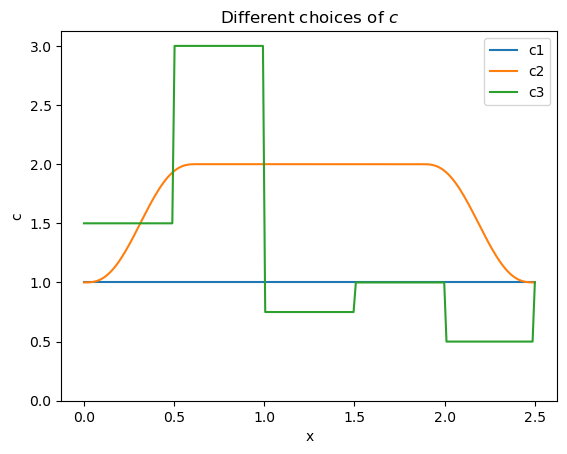

In [5]:
plt.plot(ITRC1.x_mesh, c1(ITRC1.x_mesh), label="c1")
plt.plot(ITRC2.x_mesh, c2(ITRC2.x_mesh), label="c2")
plt.plot(ITRC3.x_mesh, c3(ITRC3.x_mesh), label="c3")
plt.title("Different choices of $c$")
plt.xlabel("x")
plt.ylabel("c")
plt.ylim(bottom=0)
plt.legend()

Here, we compute travel time volumes for these three choices of $c$ without additional noise.

In [6]:
volume1 = ITRC1.travel_time_volume(maxiter=CG_maxiter, alpha_vol=alpha_vol)
volume2 = ITRC2.travel_time_volume(maxiter=CG_maxiter, alpha_vol=alpha_vol)
volume3 = ITRC3.travel_time_volume(maxiter=CG_maxiter, alpha_vol=alpha_vol)

Calculating volumes: 100%|██████████| 251/251 [00:25<00:00,  9.69it/s]


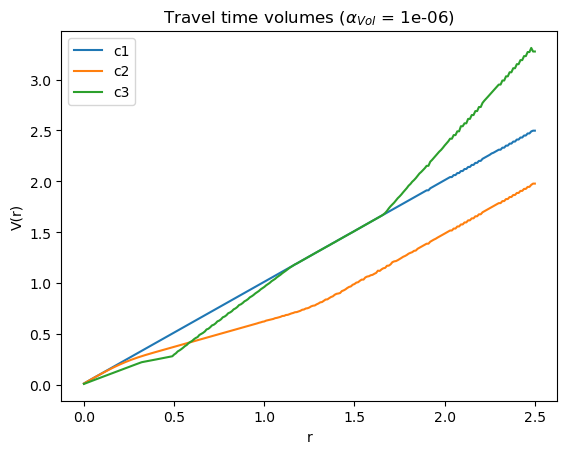

In [7]:
# Plotting
mesh_argmax = ITRC1.t_mesh[ITRC1.t_mesh <= ITRC1.T].argmax()
plt.plot(ITRC1.t_mesh[: mesh_argmax + 1], volume1, label="c1")
plt.plot(ITRC1.t_mesh[: mesh_argmax + 1], volume2, label="c2")
plt.plot(ITRC1.t_mesh[: mesh_argmax + 1], volume3, label="c3")
plt.xlabel("r")
plt.ylabel("V(r)")
plt.title(rf"Travel time volumes ($\alpha_{{Vol}}$ = {alpha_vol})")
plt.legend()

Next, we perturb each of the maps $\Lambda_i$ with i.i.d. gaussian noise, with noise level specified by the parameter `noise_level`.

In [8]:
import scipy.stats

Lambda_pert1 = Lambda_orig1 + scipy.stats.norm.rvs(
    scale=noise_level, size=ITRC1.Lambda.shape
)
Lambda_pert2 = Lambda_orig2 + scipy.stats.norm.rvs(
    scale=noise_level, size=ITRC2.Lambda.shape
)
Lambda_pert3 = Lambda_orig3 + scipy.stats.norm.rvs(
    scale=noise_level, size=ITRC3.Lambda.shape
)
ITRC1.Lambda = Lambda_pert1
ITRC2.Lambda = Lambda_pert2
ITRC3.Lambda = Lambda_pert3

We calculate the volumes again:

In [9]:
volume_pert1 = ITRC1.travel_time_volume(maxiter=CG_maxiter, alpha_vol=alpha_vol)
volume_pert2 = ITRC2.travel_time_volume(maxiter=CG_maxiter, alpha_vol=alpha_vol)
volume_pert3 = ITRC3.travel_time_volume(maxiter=CG_maxiter, alpha_vol=alpha_vol)

Calculating volumes: 100%|██████████| 251/251 [00:26<00:00,  9.63it/s]


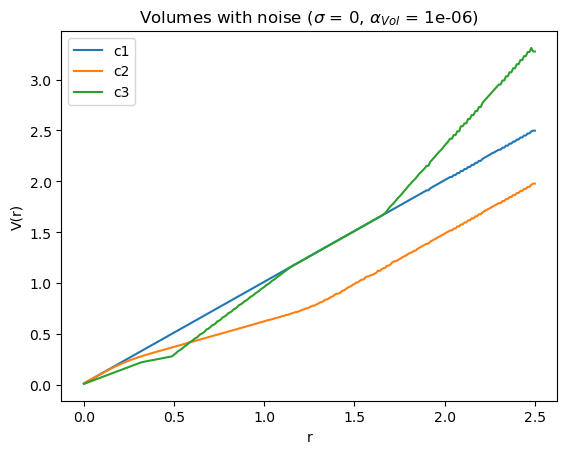

In [10]:
# Plotting
mesh_argmax = ITRC1.t_mesh[ITRC1.t_mesh <= ITRC1.T].argmax()
plt.plot(ITRC1.t_mesh[: mesh_argmax + 1], volume_pert1, label="c1")
plt.plot(ITRC1.t_mesh[: mesh_argmax + 1], volume_pert2, label="c2")
plt.plot(ITRC1.t_mesh[: mesh_argmax + 1], volume_pert3, label="c3")
plt.xlabel("r")
plt.ylabel("V(r)")
plt.title(
    rf"Volumes with noise ($\sigma$ = {noise_level}, $\alpha_{{Vol}}$ = {alpha_vol})"
)
plt.legend()

## Regularizing the numerical derivatives

Here, regularized derivatives are computed using gradient descent with the Barzilai-Borwein choice of step size.

In [11]:
from src.reg_diff import reg_diff

d1 = reg_diff(
    ITRC=ITRC1,
    u=volume_pert1,
    alpha_TV=alpha_TV,
    beta=1e-8,
    tol=1e-5,
    maxiter=10**6,
)
d2 = reg_diff(
    ITRC=ITRC2,
    u=volume_pert2,
    alpha_TV=alpha_TV,
    beta=1e-8,
    tol=1e-5,
    maxiter=10**6,
)
d3 = reg_diff(
    ITRC=ITRC3,
    u=volume_pert3,
    alpha_TV=alpha_TV,
    beta=1e-8,
    tol=1e-5,
    maxiter=10**6,
)

Minimizing TV:   0%|          | 3235/1000000 [00:00<02:08, 7756.36it/s]


Early stop on iteration 3235


Minimizing TV:   1%|          | 8125/1000000 [00:00<01:22, 12065.91it/s]


Early stop on iteration 8125


Minimizing TV:   3%|▎         | 34934/1000000 [00:03<01:32, 10484.01it/s]

Early stop on iteration 34934


We plot the results:

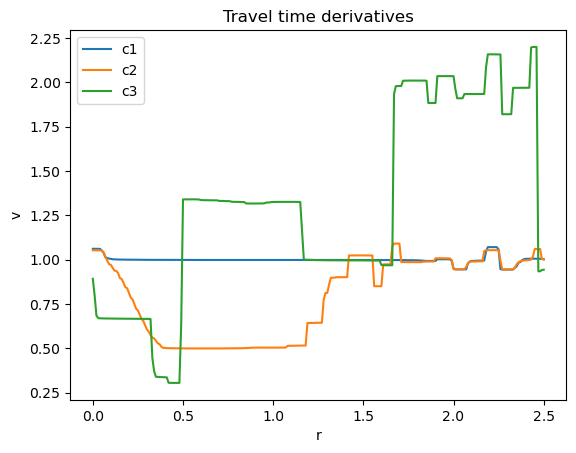

In [12]:
plt.plot(ITRC1.r_mesh, d1, label="c1")
plt.plot(ITRC1.r_mesh, d2, label="c2")
plt.plot(ITRC1.r_mesh, d3, label="c3")
plt.title("Travel time derivatives")
plt.xlabel("r")
plt.ylabel("v")
plt.legend()

Next, the cumulative integrals of the derivatives are compared against their respective volumes to assess the effect of the regularization.

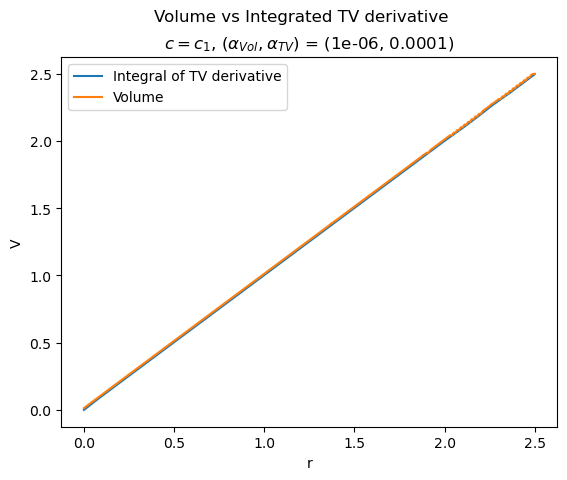

In [13]:
import plot_tools

plot_tools.reg_diff_plot(
    ITRC1, volume_pert1, d1, num=1, alpha_vol=alpha_vol, alpha_TV=alpha_TV
)

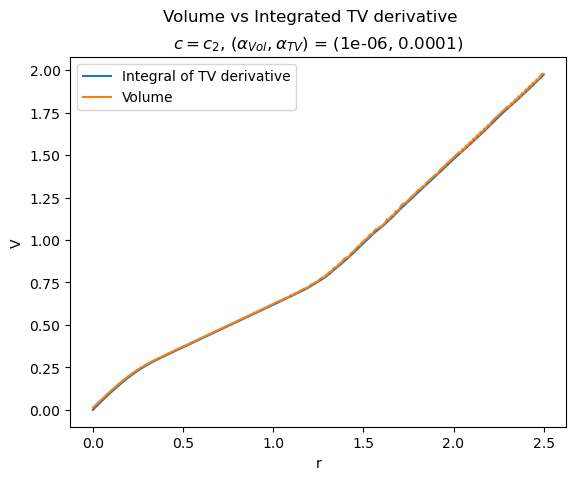

In [14]:
plot_tools.reg_diff_plot(
    ITRC2, volume_pert2, d2, num=2, alpha_vol=alpha_vol, alpha_TV=alpha_TV
)

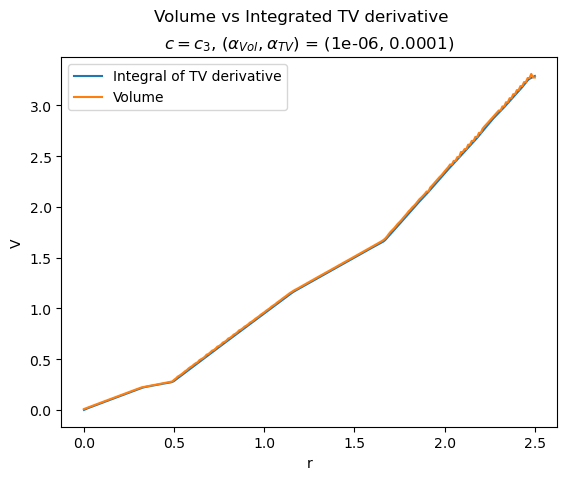

In [15]:
plot_tools.reg_diff_plot(
    ITRC3, volume_pert3, d3, num=3, alpha_vol=alpha_vol, alpha_TV=alpha_TV
)

Finally, we create reconstructions $c$ from the three derivatives:

In [16]:
ITRC1.Lambda = Lambda_pert1
ITRC2.Lambda = Lambda_pert2
ITRC3.Lambda = Lambda_pert3

c_rec1 = ITRC1.wave_speed(1 / d1)
c_rec2 = ITRC2.wave_speed(1 / d2)
c_rec3 = ITRC3.wave_speed(1 / d3)

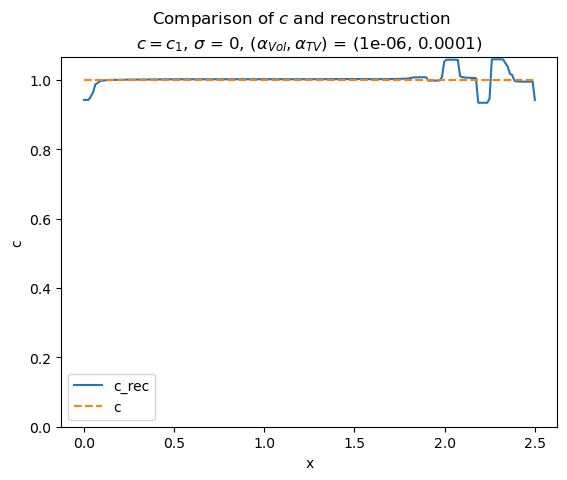

In [17]:
plot_tools.c_comparison_plot(
    ITRC1, c_rec1, c1, 1, alpha_vol, alpha_TV, sigma=noise_level
)

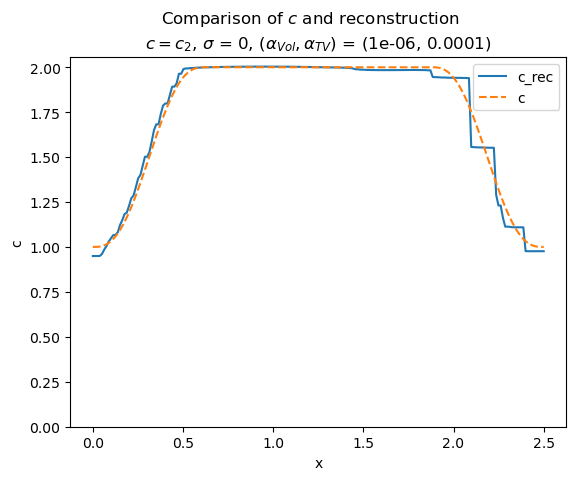

In [18]:
plot_tools.c_comparison_plot(
    ITRC2, c_rec2, c2, 2, alpha_vol, alpha_TV, sigma=noise_level
)

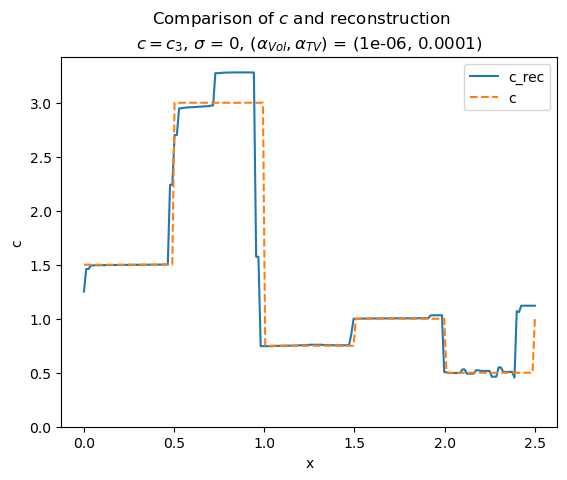

In [19]:
plot_tools.c_comparison_plot(
    ITRC3, c_rec3, c3, 3, alpha_vol, alpha_TV, sigma=noise_level
)